In [630]:
import os.path
from typing import List
from datetime import date, datetime, timedelta

import numpy as np
import pandas as pd
from pandas import DataFrame, Series
from kmodes.kmodes import KModes
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from datetime import date
from thefuzz import fuzz

%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.max_colwidth = 160

from utils.configuration import settings
from utils.utils import *
from tft.api import *

In [631]:
API_KEY: str = settings.api_key
ASSETS_DIR: str = settings.assets_dir
SERVER = 'na1'  # euw1 na1 kr oc1
LEAGUE='challengers' # challengers grandmasters
MAX_COUNT: int = settings.max_count
LATEST_RELEASE = '12.12.450.4196' # '12.12.450.4196' Version 12.12.448.6653 12.11.446.9344
PATCH: date = date(2022, 7, 1)
THREEDAY: datetime = (datetime.now() - timedelta(days=3)).strftime("%Y-%m-%d")

TARGETNAME = 'placement'

# Data Loading

In [632]:
# raw_df: DataFrame = pd.read_pickle(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{PATCH}_matches.pickle'))
raw_df: DataFrame = pd.read_pickle(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{THREEDAY}_matches.pickle'))

# Preprocessing

In [633]:
def impute(df) -> DataFrame:
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("object"):
        df[name] = df[name].fillna("None")
    return df

raw_df = impute(raw_df)

In [634]:
match_id_df: Series = raw_df['match_id']
X: DataFrame = raw_df.drop(['match_id'], axis=1)
y: Series = X.pop(TARGETNAME)
X.fillna('', inplace=True)
numeric_cols: List = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()
# traits level columns
traits_col: list = [s for s in numeric_cols if "Set7" in s]
# units level columns
units_col: list = [s for s in numeric_cols if "TFT7" in s]
# augments columns
augments_col: list[str] = ['augment0', 'augment1', 'augment2']
# units items columns
items_col = [s for s in categorical_cols if s not in augments_col]
df_unique = X.nunique().to_frame().reset_index()
df_unique.columns = ['Variable','DistinctCount']
unique_items_set = {y for col in items_col for y in X[col].unique().tolist()}
unique_augments_set = {y for col in augments_col for y in X[col].unique().tolist()}
X[f'items_count'] = X[items_col].apply(lambda row: sum(x != 'None' for x in row), axis=1)
X[f'traits_sum'] = X[traits_col].sum(axis=1)
X[f'units_sum'] = X[units_col].sum(axis=1)
X.iloc[X[f'units_sum'].idxmax()]

augment0              TFT6_Augment_SunfireBoard
augment1          TFT7_Augment_CannoneerEmblem2
augment2             TFT6_Augment_ForceOfNature
Set7_Assassin                               0.0
Set7_Astral                                 0.0
                              ...              
TFT7_Zoe_item1                             None
TFT7_Zoe_item2                             None
items_count                                  17
traits_sum                                 13.0
units_sum                                  27.0
Name: 5991, Length: 270, dtype: object

In [635]:
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()
X[numeric_cols] = X[numeric_cols].applymap(np.int64)
matches_df = X.copy()
matches_df[TARGETNAME] = y

In [636]:
def get_unit_items_ranking(df: matches_df, unit: str):
    # filter and melt the dataframe
    df = df.filter(regex=f'placement|{unit}_item0|{unit}_item1|{unit}_item2')
    df[f'unit'] = f'{unit}' # fill in current unit
    # join 3 items to 1 column
    df[f'{unit}_items'] = df[[f'{unit}_item0', f'{unit}_item1', f'{unit}_item2']].apply(lambda row: ', '.join(row.values.astype(str)), axis=1)
    # sort items for unique combination
    df[f'{unit}_items'] = df[f'{unit}_items'].apply(lambda x: ', '.join(sorted(x.split(', '))))
    df = df.filter(regex=f'placement|{unit}_items|unit')
    m = df.melt(
        ['placement',f'unit'], value_name=f'{unit}_items_grp') #, value_vars=[f'{unit}_items', f'{unit}']
    # group and aggregate mean/median average_placement
    dct = {'value_count': (f'{unit}_items_grp', 'count'),
           'average_placement': ('placement', 'mean')}
    return m.groupby([f'unit', f'{unit}_items_grp'], as_index=False).agg(**dct).sort_values(by='average_placement')

In [637]:
get_unit_items_ranking(df = matches_df[:2], unit='TFT7_Zoe')

,unit,TFT7_Zoe_items_grp,value_count,average_placement
0,TFT7_Zoe,"None, None, None",2,7.5


In [638]:
# Get top5 
top5_items_list = []
for unit in units_col:
    df = get_unit_items_ranking(df = matches_df, unit=unit)
    df = df[df['value_count']>=12][:5] #Top 5 with counts >= 12
    top5_items_list.extend(df.values)

In [639]:
top5_items_list = pd.DataFrame(top5_items_list, columns=['unit', 'items',	'value_count',	'average_placement'])

In [640]:
top5_items_list.to_csv(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{PATCH}_top5_items.csv'), index=False)

In [641]:
top5_items_list.groupby('unit').head(1)

,unit,items,value_count,average_placement
0,TFT7_Aatrox,"None, None, None",8821,4.497336
1,TFT7_Anivia,"Morellonomicon, None, None",19,4.368421
6,TFT7_AoShin,"ArchangelsStaff, MadredsBloodrazor, SpearOfShojin",20,2.850000
11,TFT7_Ashe,"Chalice, None, None",14,3.714286
16,TFT7_AurelionSol,"None, None, None",8867,4.498026
17,TFT7_Bard,"LocketOfTheIronSolari, None, None",16,2.375000
22,TFT7_Braum,"None, None, Zephyr",12,2.833333
25,TFT7_Corki,"GuinsoosRageblade, MadredsBloodrazor, UnstableConcoction",46,3.826087
30,TFT7_Diana,"FrozenHeart, IonicSpark, RedBuff",12,2.500000
33,TFT7_DragonBlue,"GuinsoosRageblade, RevelEmblemItem, StatikkShiv",15,3.000000


# Load TFT asset

In [642]:
tft_assets = read_json(os.path.join(ASSETS_DIR, f'en_us.json'))

In [643]:
tft7_set = tft_assets['setData'][6]['champions'] #['apiName'] ['traits']['name'] #['champions'] #['champions'].name

In [644]:
champions_dict = {}

for champion in tft7_set:
    if champion["apiName"] not in champions_dict:
        champions_dict[champion["apiName"]] = []
    for trait in champion["traits"]:
        champions_dict[champion["apiName"]].append(trait)

In [645]:
champions_dict['TFT7_Olaf']

['Scalescorn', 'Bruiser', 'Warrior']

# Team Composition Ranking

In [646]:
def add_traits(units_str):
    # for units in units_str.split(', '):
    comp_array = []
    if len(units_str) == 0:
        return ''
    for unit in units_str.split(', '):
        traits_array = []
        for trait in champions_dict[unit]:
            traits_array.append(trait[:2]+trait[-1:]) # Add first 2 char for trait
        traits_str = '-'.join(traits_array) + f'-{unit}'
        comp_array.append(traits_str)

    # print(f'{"".join(comp_array)}')
    return ','.join(comp_array)

def get_unit_comp_ranking(df: DataFrame, add_trait=True):
    # filter and melt the dataframe
    df = df.filter(['placement']+units_col)
    # join units lvl > 0 to 1 column
    df['comp'] = df[units_col].apply(lambda row: ', '.join(row[row > 0].index.values.astype(str)), axis=1)
    if add_trait:
        df['comp'] = df['comp'].apply(add_traits)

    df['comp'] = df['comp'].str.replace('TFT7_','') # remove prefix .split('_',1).str[-1]
    df = df.filter(['placement', 'comp'])
    m = df.melt(
        ['placement'], value_name=f'comp_grp')
    # group and aggregate mean/median average_placement
    dct = {'value_count': (f'comp_grp', 'count'),
           'average_placement': ('placement', 'mean')}
    return m.groupby([f'comp_grp'], as_index=False).agg(**dct).sort_values(by='average_placement')

In [647]:
# Get top5 
comp_df = get_unit_comp_ranking(df = matches_df)

In [648]:
top5_comp_list = []
m = comp_df[comp_df['value_count']>=1] #[:5] #Top 5 with counts >= 12
top5_comp_list.extend(m.values)
comp_ranking_df = pd.DataFrame(top5_comp_list, columns=['comp', 'value_count', 'average_placement'])

In [649]:
comp_ranking_df #.groupby('comp').head(1)

,comp,value_count,average_placement
0,"Rel-Car-Corki,She-Drn-Gun-DragonGold,Trr-Myc-Evr-Lulu,Whs-Asn-Pyke,Rel-Evr-Sona,Gud-Asn-Talon,Whs-Gun-Thresh,-TrainerDragon,Trr-Car-Tristana",1,1.0
1,"Gud-Myc-Bad-Bard,Whs-Brr-Drn-DragonPurple,Tet-Brr-Led-Ornn,Whs-Asn-Pyke,Tet-Asn-Qiyana,Rag-Brr-War-Shen,Jae-Str-Soraka,Whs-Mae-Brr-Sylas,Mie-Drr-War-Yasuo",1,1.0
2,"Gud-Myc-Bad-Bard,Whs-Brr-Drn-DragonPurple,Tet-Brr-Led-Ornn,Whs-Asn-Pyke,Tet-Asn-Qiyana,Rag-Brr-War-Shen,Whs-Mae-Brr-Sylas",1,1.0
3,"Gud-Myc-Bad-Bard,Whs-Brr-Drn-DragonPurple,Tet-Brr-Led-Ornn,Whs-Asn-Pyke,Tet-Asn-Qiyana,Rag-Brr-War-Shen,Whs-Mae-Brr-Sylas,Mie-Drr-War-Yasuo",2,1.0
4,"Gud-Myc-Bad-Bard,Whs-Brr-Drn-DragonPurple,Tet-Brr-Led-Ornn,Whs-Asn-Pyke,Whs-Mae-Brr-Sylas,Gud-Asn-Talon,Whs-Gun-Thresh,Mie-Drr-War-Yasuo",2,1.0
...,...,...,...
5335,"Jae-Evr-Led-Anivia,Rag-Car-Hecarim,Scn-Car-Mae-Lillia,Mie-Car-Nunu,Rel-Evr-Sona,She-Drr-Led-Volibear",1,8.0
5336,"Whs-Brr-Drn-DragonPurple,Rag-Car-Hecarim,Tet-Asn-Qiyana,Whs-Mae-Brr-Sylas,Gud-Swt-Twitch,Rag-Swt-Xayah",1,8.0
5337,"Whs-Brr-Drn-DragonPurple,Rag-Car-Hecarim,Tet-Brr-Led-Ornn,Gud-Car-Sejuani,Rag-Brr-War-Shen,Gud-Swt-Twitch,Rag-Swt-Xayah",1,8.0
5338,"Jae-Evr-Led-Anivia,Mie-Drn-DragonBlue,Rag-Car-Hecarim,Mie-Car-Nunu,Gud-Car-Sejuani,Mie-War-Yone",1,8.0


In [650]:
composition_ranking_df = comp_ranking_df.copy()

# Team composition Clustering

In [651]:
from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer('all-MiniLM-L6-v2')

--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\furyx\miniconda3\envs\tft\lib\logging\__init__.py", line 1104, in emit
    self.flush()
  File "c:\Users\furyx\miniconda3\envs\tft\lib\logging\__init__.py", line 1084, in flush
    self.stream.flush()
OSError: [Errno 22] Invalid argument
Call stack:
  File "c:\Users\furyx\miniconda3\envs\tft\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\furyx\miniconda3\envs\tft\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c:\Users\furyx\miniconda3\envs\tft\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Users\furyx\miniconda3\envs\tft\lib\site-packages\traitlets\config\application.py", line 976, in launch_instance
    app.start()
  File "c:\Users\furyx\miniconda3\envs\tft\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
    self.io_loop.start()
  File "c:\Users\furyx\m

In [652]:
corpus_sentences = list(comp_ranking_df['comp'])

corpus_embeddings = embedder.encode(corpus_sentences, batch_size=512, show_progress_bar=True, convert_to_tensor=True)
# Normalize the embeddings to unit length
# corpus_embeddings = corpus_embeddings /  np.linalg.norm(corpus_embeddings, axis=1, keepdims=True)

Batches: 100%|██████████| 11/11 [01:31<00:00,  8.29s/it]


In [653]:
clustering_model = DBSCAN(eps=0.023, min_samples=1, metric='cosine', n_jobs=-1)
predict=clustering_model.fit_predict(corpus_embeddings)
comp_ranking_df['group'] = pd.Series(predict, index=comp_ranking_df.index)

In [654]:
comp_ranking_df.sort_values(by='group')

,comp,value_count,average_placement,group
0,"Rel-Car-Corki,She-Drn-Gun-DragonGold,Trr-Myc-Evr-Lulu,Whs-Asn-Pyke,Rel-Evr-Sona,Gud-Asn-Talon,Whs-Gun-Thresh,-TrainerDragon,Trr-Car-Tristana",1,1.000000,0
2597,"Rel-Car-Corki,She-Drn-Gun-DragonGold,Trr-Myc-Evr-Lulu,Tet-Brr-Led-Ornn,Rel-Evr-Sona,Rel-Brr-TahmKench,-TrainerDragon,Trr-Car-Tristana",2,4.500000,0
2598,"Rel-Car-Corki,She-Drn-Gun-DragonGold,Rel-Car-Jinx,Trr-Myc-Evr-Lulu,Rel-Evr-Sona,Jae-Str-Soraka,-TrainerDragon,Trr-Car-Tristana",4,4.500000,0
2612,"Rel-Car-Corki,She-Drn-Gun-DragonGold,Rel-Car-Jinx,Trr-Myc-Evr-Lulu,Rag-Car-Senna,Rel-Evr-Sona,-TrainerDragon,Trr-Car-Tristana",3,4.666667,0
2641,"Rel-Car-Corki,She-Drn-Gun-DragonGold,Rel-Car-Jinx,Trr-Myc-Evr-Lulu,Rel-Evr-Sona,-TrainerDragon,Trr-Car-Tristana,Mie-Drr-War-Yasuo",8,4.875000,0
...,...,...,...,...
5332,"Mie-Drn-DragonBlue,She-Drn-Gun-DragonGold,Rag-She-Asn-Kayn,Mie-Gun-Leona,She-Drr-Led-Volibear,She-Spf-Mae-Zoe",1,8.000000,1910
5333,"Rel-Car-Jinx,Trr-Myc-Evr-Lulu,Rag-Brr-War-Shen,Rel-Evr-Sona,Rel-Brr-TahmKench,Gud-Asn-Talon,-TrainerDragon,Trr-Car-Tristana",1,8.000000,1911
5335,"Jae-Evr-Led-Anivia,Rag-Car-Hecarim,Scn-Car-Mae-Lillia,Mie-Car-Nunu,Rel-Evr-Sona,She-Drr-Led-Volibear",1,8.000000,1912
5336,"Whs-Brr-Drn-DragonPurple,Rag-Car-Hecarim,Tet-Asn-Qiyana,Whs-Mae-Brr-Sylas,Gud-Swt-Twitch,Rag-Swt-Xayah",1,8.000000,1913


In [655]:
comp_ranking_df['grp_count'] = comp_ranking_df.groupby(['group'], as_index=False)['value_count'].transform('sum')
comp_ranking_df['grp_placement'] = comp_ranking_df.groupby(['group'], as_index=False)['average_placement'].transform('mean')

In [656]:
comp_ranking_df.sort_values(by='group')[:60]

,comp,value_count,average_placement,group,grp_count,grp_placement
0,"Rel-Car-Corki,She-Drn-Gun-DragonGold,Trr-Myc-Evr-Lulu,Whs-Asn-Pyke,Rel-Evr-Sona,Gud-Asn-Talon,Whs-Gun-Thresh,-TrainerDragon,Trr-Car-Tristana",1,1.000000,0,198,5.379357
2597,"Rel-Car-Corki,She-Drn-Gun-DragonGold,Trr-Myc-Evr-Lulu,Tet-Brr-Led-Ornn,Rel-Evr-Sona,Rel-Brr-TahmKench,-TrainerDragon,Trr-Car-Tristana",2,4.500000,0,198,5.379357
2598,"Rel-Car-Corki,She-Drn-Gun-DragonGold,Rel-Car-Jinx,Trr-Myc-Evr-Lulu,Rel-Evr-Sona,Jae-Str-Soraka,-TrainerDragon,Trr-Car-Tristana",4,4.500000,0,198,5.379357
2612,"Rel-Car-Corki,She-Drn-Gun-DragonGold,Rel-Car-Jinx,Trr-Myc-Evr-Lulu,Rag-Car-Senna,Rel-Evr-Sona,-TrainerDragon,Trr-Car-Tristana",3,4.666667,0,198,5.379357
2641,"Rel-Car-Corki,She-Drn-Gun-DragonGold,Rel-Car-Jinx,Trr-Myc-Evr-Lulu,Rel-Evr-Sona,-TrainerDragon,Trr-Car-Tristana,Mie-Drr-War-Yasuo",8,4.875000,0,198,5.379357
2659,"Rel-Car-Corki,She-Drn-Gun-DragonGold,Trr-Mae-Heimerdinger,Rel-Car-Jinx,Trr-Myc-Evr-Lulu,Rel-Evr-Sona,-TrainerDragon,Trr-Car-Tristana",1,5.000000,0,198,5.379357
2671,"Rel-Car-Corki,She-Drn-Gun-DragonGold,Rel-Car-Jinx,Trr-Myc-Evr-Lulu,Tet-Brr-Led-Ornn,Rag-Car-Senna,Rel-Evr-Sona,-TrainerDragon,Trr-Car-Tristana",1,5.000000,0,198,5.379357
2674,"Rel-Car-Corki,She-Drn-Gun-DragonGold,Trr-Myc-Evr-Lulu,Rag-Brr-War-Shen,Rel-Evr-Sona,Jae-Gun-Taric,-TrainerDragon,Trr-Car-Tristana,Mie-Drr-War-Yasuo",1,5.000000,0,198,5.379357
2576,"Rel-Car-Corki,She-Drn-Gun-DragonGold,Trr-Myc-Evr-Lulu,Rel-Evr-Sona,Gud-Asn-Talon,Whs-Gun-Thresh,-TrainerDragon,Trr-Car-Tristana",8,4.500000,0,198,5.379357
2692,"Rel-Car-Corki,She-Drn-Gun-DragonGold,Trr-Myc-Evr-Lulu,Rel-Evr-Sona,Whs-Gun-Thresh,-TrainerDragon,Trr-Car-Tristana,She-Drr-Led-Volibear",1,5.000000,0,198,5.379357


In [657]:
top5_comp_ranking_list = []
m = comp_ranking_df[comp_ranking_df['grp_count']>=10] #[:5] #Top 5 with counts >= 12
top5_comp_ranking_list.extend(m.values)
top_comp_ranking_df = pd.DataFrame(top5_comp_ranking_list, columns=['comp', 'value_count', 'average_placement', 'group', 'grp_count', 'grp_placement'])

In [658]:
def remove_traits(units_str):
    """Remove units traits from text seperated by comma

    Args:
        units_str (str): traits-unit,traits-unit

    Returns:
        str: Units stripped of traits
    """    
    if len(units_str) == 0:
        return ''

    units_array = []
    for unit in units_str.split(','):
        units_array.append(unit.split('-')[-1])
    units = ', '.join(units_array)
    return units

top_comp_ranking_df['comp'] = top_comp_ranking_df['comp'].apply(remove_traits)


In [659]:
top_comp_ranking_df['mode'] = top_comp_ranking_df.groupby('group')['comp'].transform(lambda x: pd.Series.mode(x)[0])
top_comp_ranking_df.groupby(['group']).head(1).sort_values(by='grp_placement')

,comp,value_count,average_placement,group,grp_count,grp_placement,mode
32,"Bard, Heimerdinger, Illaoi, Lulu, Nami, Sona, Sylas, TrainerDragon, Twitch, Varus, Zoe",1,1.0,14,28,2.277778,"Bard, DragonPurple, Heimerdinger, Illaoi, Lulu, Nami, Sona, TrainerDragon, Twitch, Varus"
224,"Aatrox, Bard, DragonGold, Kayn, Thresh, Volibear, Yasuo, Zoe",1,1.0,144,16,2.461538,"Aatrox, Bard, Corki, DragonGold, Kayn, Ornn, Volibear, Yasuo, Zoe"
187,"AoShin, Bard, Heimerdinger, Lulu, Ornn, Sylas, TrainerDragon, Twitch, Zoe",1,1.0,107,59,2.547619,"AoShin, Bard, Heimerdinger, Illaoi, Lulu, Nami, Sylas, TrainerDragon, Zoe"
89,"Bard, Corki, DragonBlue, Jinx, Lulu, Ornn, Sona, TahmKench, Yasuo",1,1.0,45,20,2.719780,"Bard, Corki, DragonBlue, Hecarim, Jinx, Shen, Sona, TahmKench, Yasuo"
173,"AoShin, Bard, Neeko, Ornn, Sejuani, Shen, Soraka, Yasuo",1,1.0,91,24,2.848485,"AoShin, Bard, DragonGreen, Gnar, Neeko, Ornn, Soraka, Talon, Yasuo"
22,"Bard, DragonPurple, Pyke, Ryze, Sylas, Talon, Yasuo, Zoe",1,1.0,5,12,2.909091,"Bard, Corki, DragonPurple, Lulu, Ornn, Sona, Sylas, Zoe"
119,"Bard, Hecarim, Lillia, Nunu, Ryze, Sejuani, Talon, Twitch, Yasuo",1,1.0,62,22,3.027778,"Bard, DragonBlue, Hecarim, Leona, Lillia, Nunu, Sejuani, Twitch, Yasuo"
7,"Bard, DragonPurple, Ezreal, Illaoi, Ornn, Sylas, Twitch, Varus",1,1.0,2,40,3.161905,"Bard, Braum, Diana, Olaf, Ornn, Qiyana, Shen, Talon, Twitch"
8,"Bard, DragonPurple, Heimerdinger, Illaoi, Lulu, Ryze, Shen, Sylas, TrainerDragon",1,1.0,3,558,3.316063,"Bard, Braum, Corki, DragonGold, Heimerdinger, Jinx, Lulu, Sona, TrainerDragon, Tristana"
283,"Diana, DragonPurple, Elise, Ornn, Pyke, Qiyana, Shen, Sylas, Talon",1,1.0,178,13,3.363636,"Diana, DragonPurple, Elise, Neeko, Ornn, Pyke, Sylas, Talon"


In [660]:
comp_ranking_df['comp'] = comp_ranking_df['comp'].apply(remove_traits)
comp_ranking_df.to_csv(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{PATCH}_comp_ranking.csv'), index=False)

In [661]:
# from statistics import mode
# import jellyfish

# import pandas as pd

# df = pd.DataFrame({'Code': ['abc', 'abc', 'abc', 'abcc', 'abcc', 'zxc'],
#                    'Description': ['ABC String', 'abc string', 'ABC String and sth', 'abc sth else', 'zxc sth else', 'zxc zxc'],
#                 #    'Value': [10, 20, 30, 40, 100]
#                    })

# df_list = []
# for grp,df in df.groupby('Code'):
#     df['distance'] = df['Description'].apply(lambda x : fuzz.token_set_ratio(x, mode(df['Description'])))
#     # df['Description'] =  mode(df['Description'])
#     df_list.append(df[df['distance'] > 10])

# df = pd.concat(df_list)

In [662]:
# comp_ranking_df.groupby('comp')['comp'].apply(lambda x : fuzz.token_set_ratio(x, ','.join(units_col)))

In [663]:
# df_list = []
# for grp,df in comp_ranking_df.groupby('comp'):
#     df['distance'] = df['comp'].apply(lambda x : fuzz.token_set_ratio(x, 'Aatrox, DragonGold, Kayn, Shen, Twitch, Xayah, Zoe'))
#     # df['Description'] =  mode(df['Description'])
#     df_list.append(df[df['distance'] > 10])

# df = pd.concat(df_list)

In [664]:
composition_ranking_df

,comp,value_count,average_placement
0,"Rel-Car-Corki,She-Drn-Gun-DragonGold,Trr-Myc-Evr-Lulu,Whs-Asn-Pyke,Rel-Evr-Sona,Gud-Asn-Talon,Whs-Gun-Thresh,-TrainerDragon,Trr-Car-Tristana",1,1.0
1,"Gud-Myc-Bad-Bard,Whs-Brr-Drn-DragonPurple,Tet-Brr-Led-Ornn,Whs-Asn-Pyke,Tet-Asn-Qiyana,Rag-Brr-War-Shen,Jae-Str-Soraka,Whs-Mae-Brr-Sylas,Mie-Drr-War-Yasuo",1,1.0
2,"Gud-Myc-Bad-Bard,Whs-Brr-Drn-DragonPurple,Tet-Brr-Led-Ornn,Whs-Asn-Pyke,Tet-Asn-Qiyana,Rag-Brr-War-Shen,Whs-Mae-Brr-Sylas",1,1.0
3,"Gud-Myc-Bad-Bard,Whs-Brr-Drn-DragonPurple,Tet-Brr-Led-Ornn,Whs-Asn-Pyke,Tet-Asn-Qiyana,Rag-Brr-War-Shen,Whs-Mae-Brr-Sylas,Mie-Drr-War-Yasuo",2,1.0
4,"Gud-Myc-Bad-Bard,Whs-Brr-Drn-DragonPurple,Tet-Brr-Led-Ornn,Whs-Asn-Pyke,Whs-Mae-Brr-Sylas,Gud-Asn-Talon,Whs-Gun-Thresh,Mie-Drr-War-Yasuo",2,1.0
...,...,...,...
5335,"Jae-Evr-Led-Anivia,Rag-Car-Hecarim,Scn-Car-Mae-Lillia,Mie-Car-Nunu,Rel-Evr-Sona,She-Drr-Led-Volibear",1,8.0
5336,"Whs-Brr-Drn-DragonPurple,Rag-Car-Hecarim,Tet-Asn-Qiyana,Whs-Mae-Brr-Sylas,Gud-Swt-Twitch,Rag-Swt-Xayah",1,8.0
5337,"Whs-Brr-Drn-DragonPurple,Rag-Car-Hecarim,Tet-Brr-Led-Ornn,Gud-Car-Sejuani,Rag-Brr-War-Shen,Gud-Swt-Twitch,Rag-Swt-Xayah",1,8.0
5338,"Jae-Evr-Led-Anivia,Mie-Drn-DragonBlue,Rag-Car-Hecarim,Mie-Car-Nunu,Gud-Car-Sejuani,Mie-War-Yone",1,8.0


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 582, cost: 8536.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 62, cost: 9046.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 3147, cost: 9255.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 597, cost: 9116.0
Run 4, iteration: 2/100, moves: 2134, cost: 9116.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 8632.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 15, cost: 7877.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 8167.0
Init: initializing cen

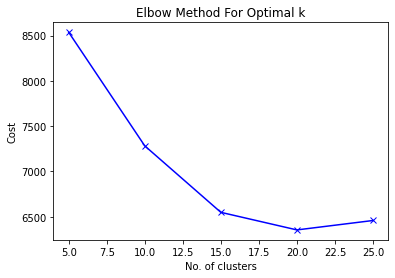

In [665]:
# Elbow curve to find optimal K
cost = []
K = range(5,30,5)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=1)
    kmode.fit_predict(composition_ranking_df)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [666]:
# Building the model with 3 clusters
kmode = KModes(n_clusters=10, init = "random", n_init = 5, verbose=1)
clusters = kmode.fit_predict(composition_ranking_df)
clusters

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 58, cost: 7613.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 93, cost: 8583.0
Run 2, iteration: 2/100, moves: 1, cost: 8583.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 36, cost: 8151.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 8533.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 648, cost: 9079.0
Best run was number 1


array([1, 1, 1, ..., 0, 0, 0], dtype=uint16)

In [667]:
kmode_ranking_df = composition_ranking_df.copy()
kmode_ranking_df.insert(0, "group", clusters, True)

In [668]:
kmode_ranking_df

,group,comp,value_count,average_placement
0,1,"Rel-Car-Corki,She-Drn-Gun-DragonGold,Trr-Myc-Evr-Lulu,Whs-Asn-Pyke,Rel-Evr-Sona,Gud-Asn-Talon,Whs-Gun-Thresh,-TrainerDragon,Trr-Car-Tristana",1,1.0
1,1,"Gud-Myc-Bad-Bard,Whs-Brr-Drn-DragonPurple,Tet-Brr-Led-Ornn,Whs-Asn-Pyke,Tet-Asn-Qiyana,Rag-Brr-War-Shen,Jae-Str-Soraka,Whs-Mae-Brr-Sylas,Mie-Drr-War-Yasuo",1,1.0
2,1,"Gud-Myc-Bad-Bard,Whs-Brr-Drn-DragonPurple,Tet-Brr-Led-Ornn,Whs-Asn-Pyke,Tet-Asn-Qiyana,Rag-Brr-War-Shen,Whs-Mae-Brr-Sylas",1,1.0
3,1,"Gud-Myc-Bad-Bard,Whs-Brr-Drn-DragonPurple,Tet-Brr-Led-Ornn,Whs-Asn-Pyke,Tet-Asn-Qiyana,Rag-Brr-War-Shen,Whs-Mae-Brr-Sylas,Mie-Drr-War-Yasuo",2,1.0
4,1,"Gud-Myc-Bad-Bard,Whs-Brr-Drn-DragonPurple,Tet-Brr-Led-Ornn,Whs-Asn-Pyke,Whs-Mae-Brr-Sylas,Gud-Asn-Talon,Whs-Gun-Thresh,Mie-Drr-War-Yasuo",2,1.0
...,...,...,...,...
5335,0,"Jae-Evr-Led-Anivia,Rag-Car-Hecarim,Scn-Car-Mae-Lillia,Mie-Car-Nunu,Rel-Evr-Sona,She-Drr-Led-Volibear",1,8.0
5336,0,"Whs-Brr-Drn-DragonPurple,Rag-Car-Hecarim,Tet-Asn-Qiyana,Whs-Mae-Brr-Sylas,Gud-Swt-Twitch,Rag-Swt-Xayah",1,8.0
5337,0,"Whs-Brr-Drn-DragonPurple,Rag-Car-Hecarim,Tet-Brr-Led-Ornn,Gud-Car-Sejuani,Rag-Brr-War-Shen,Gud-Swt-Twitch,Rag-Swt-Xayah",1,8.0
5338,0,"Jae-Evr-Led-Anivia,Mie-Drn-DragonBlue,Rag-Car-Hecarim,Mie-Car-Nunu,Gud-Car-Sejuani,Mie-War-Yone",1,8.0


In [669]:
kmode_ranking_df['grp_count'] = kmode_ranking_df.groupby(['group'], as_index=False)['value_count'].transform('sum')
kmode_ranking_df['grp_placement'] = kmode_ranking_df.groupby(['group'], as_index=False)['average_placement'].transform('mean')

In [670]:
top5_comp_ranking_list = []
m = comp_ranking_df[comp_ranking_df['grp_count']>=10] #[:5] #Top 5 with counts >= 12
top5_comp_ranking_list.extend(m.values)
top_comp_ranking_df = pd.DataFrame(top5_comp_ranking_list, columns=['comp', 'value_count', 'average_placement', 'group', 'grp_count', 'grp_placement'])

In [671]:
kmode_ranking_df['comp'] = kmode_ranking_df['comp'].apply(remove_traits)
kmode_ranking_df['mode'] = kmode_ranking_df.groupby('group')['comp'].transform(lambda x: pd.Series.mode(x)[0])
kmode_ranking_df.groupby(['group']).head(1).sort_values(by='grp_placement')

,group,comp,value_count,average_placement,grp_count,grp_placement,mode
0,1,"Corki, DragonGold, Lulu, Pyke, Sona, Talon, Thresh, TrainerDragon, Tristana",1,1.00,597,1.000000,"Aatrox, Bard, Corki, DragonGold, Kayn, Sona, Volibear, Zoe"
391,2,"Ashe, Braum, DragonGreen, Karma, Leona, Taric, Thresh, Yasuo",1,1.00,1,1.000000,"Ashe, Braum, DragonGreen, Karma, Leona, Taric, Thresh, Yasuo"
1310,3,"Anivia, Bard, DragonGreen, Gnar, Lulu, Nami, Neeko",1,3.00,667,3.000000,"Aatrox, Bard, Corki, DragonGold, Kayn, Pyke, Soraka, Zoe"
1484,7,"Corki, DragonGold, Lulu, Pyke, Sona, Soraka, Thresh, TrainerDragon, Tristana",1,3.00,1,3.000000,"Corki, DragonGold, Lulu, Pyke, Sona, Soraka, Thresh, TrainerDragon, Tristana"
1840,8,"Corki, DragonPurple, Heimerdinger, Lulu, Ornn, Sona, Sylas, TahmKench, TrainerDragon, Zoe",1,3.00,1,3.000000,"Corki, DragonPurple, Heimerdinger, Lulu, Ornn, Sona, Sylas, TahmKench, TrainerDragon, Zoe"
583,6,"Bard, Illaoi, Lulu, Nami, Sylas, Twitch, Varus, Yasuo, Zoe",2,1.50,642,4.325472,"Aatrox, DragonGold, Hecarim, Kayn, Volibear, Xayah, Yasuo, Zoe"
575,0,"Bard, DragonGreen, Elise, Gnar, Neeko, Nidalee, Pyke, Soraka",4,1.25,4912,4.807655,
2645,4,"DragonBlue, DragonGold, DragonPurple, Nunu, Yasuo",1,5.00,749,5.000000,"Aatrox, AoShin, Jinx, Ornn, Shen, Twitch, Yasuo, Zoe"
3340,5,"Anivia, Ashe, DragonGreen, Gnar, Lulu, Neeko, Shen, Yasuo",1,6.00,727,6.000000,"Aatrox, Anivia, Ashe, Gnar, Karma, Neeko, Taric"
4016,9,"Ashe, Karma, Neeko, Sett, Shen, Swain, Volibear",1,7.00,615,7.000000,"Aatrox, Anivia, DragonGold, Kayn, Ornn, Volibear, Yasuo"


In [672]:
def get_unit_composition(df: matches_df):
    # filter and melt the dataframe
    df = df.filter(['placement']+units_col+traits_col)
    return df.sort_values(by='placement')

In [673]:
units_comp_df:DataFrame = get_unit_composition(matches_df)

In [674]:
units_comp_df

,placement,TFT7_Aatrox,TFT7_Anivia,TFT7_AoShin,TFT7_Ashe,TFT7_AurelionSol,TFT7_Bard,TFT7_Braum,TFT7_Corki,TFT7_Diana,...,Set7_Scalescorn,Set7_Shapeshifter,Set7_Shimmerscale,Set7_SpellThief,Set7_Starcaller,Set7_Swiftshot,Set7_Tempest,Set7_Trainer,Set7_Warrior,Set7_Whispers
6001,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8149,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
951,1,0,0,0,0,0,0,0,0,0,...,0,0,2,1,0,1,0,0,0,0
6326,1,0,0,2,0,0,2,0,0,0,...,0,0,0,0,0,0,3,0,0,0
1942,1,0,0,2,0,0,2,0,0,0,...,0,1,0,0,1,0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2393,8,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,1,0,0,3
2401,8,0,2,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
6985,8,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2356,8,0,0,0,0,0,0,0,2,0,...,0,0,1,0,0,0,0,1,0,0


## KMode

In [675]:
units_composition_df = units_comp_df.copy()

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1990, cost: 100745.0
Run 1, iteration: 2/100, moves: 492, cost: 100745.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 2877, cost: 99295.0
Run 2, iteration: 2/100, moves: 542, cost: 99288.0
Run 2, iteration: 3/100, moves: 14, cost: 99288.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 2159, cost: 101340.0
Run 3, iteration: 2/100, moves: 904, cost: 100720.0
Run 3, iteration: 3/100, moves: 103, cost: 100720.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 3514, cost: 98297.0
Run 4, iteration: 2/100, moves: 458, cost: 98297.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 3232, cost: 107607.0
Run 5, iteration: 2/100, move

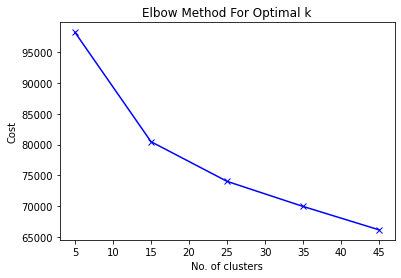

In [676]:
# Elbow curve to find optimal K
cost = []
K = range(5,50,10)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=1)
    kmode.fit_predict(units_composition_df)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [677]:
# Building the model with 3 clusters
kmode = KModes(n_clusters=25, init = "random", n_init = 5, verbose=1)
clusters = kmode.fit_predict(units_composition_df)
clusters

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 3056, cost: 74673.0
Run 1, iteration: 2/100, moves: 888, cost: 74119.0
Run 1, iteration: 3/100, moves: 341, cost: 73886.0
Run 1, iteration: 4/100, moves: 127, cost: 73843.0
Run 1, iteration: 5/100, moves: 64, cost: 73805.0
Run 1, iteration: 6/100, moves: 13, cost: 73805.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 3346, cost: 75368.0
Run 2, iteration: 2/100, moves: 1288, cost: 74743.0
Run 2, iteration: 3/100, moves: 288, cost: 74485.0
Run 2, iteration: 4/100, moves: 96, cost: 74485.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 2953, cost: 75323.0
Run 3, iteration: 2/100, moves: 1004, cost: 74478.0
Run 3, iteration: 3/100, moves: 354, cost: 74340.0
Run 3, iteration: 4/100, moves: 91, cost: 74340.0
Init: initializing centroids
Init: initializi

array([ 9,  9, 15, ..., 16, 11,  4], dtype=uint16)

In [678]:
kmode_ranking_df = units_composition_df.copy()
kmode_ranking_df.insert(0, "group", clusters, True)

In [679]:
kmode_ranking_df

,group,placement,TFT7_Aatrox,TFT7_Anivia,TFT7_AoShin,TFT7_Ashe,TFT7_AurelionSol,TFT7_Bard,TFT7_Braum,TFT7_Corki,...,Set7_Scalescorn,Set7_Shapeshifter,Set7_Shimmerscale,Set7_SpellThief,Set7_Starcaller,Set7_Swiftshot,Set7_Tempest,Set7_Trainer,Set7_Warrior,Set7_Whispers
6001,9,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8149,9,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
951,15,1,0,0,0,0,0,0,0,0,...,0,0,2,1,0,1,0,0,0,0
6326,22,1,0,0,2,0,0,2,0,0,...,0,0,0,0,0,0,3,0,0,0
1942,8,1,0,0,2,0,0,2,0,0,...,0,1,0,0,1,0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2393,14,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,3
2401,2,8,0,2,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
6985,16,8,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2356,11,8,0,0,0,0,0,0,0,2,...,0,0,1,0,0,0,0,1,0,0


In [680]:
def get_unit_composition_ranking(df: DataFrame, add_trait=True):
    # filter and melt the dataframe
    df = df.filter(['placement', 'group']+units_col)
    # join units lvl > 0 to 1 column
    df['comp'] = df[units_col].apply(lambda row: ', '.join(
        row[row > 0].index.values.astype(str)), axis=1)

    if add_trait:
        df['comp'] = df['comp'].apply(add_traits)

    df['comp'] = df['comp'].str.replace('TFT7_', '')
    df = df.filter(['placement', 'group', 'comp'])
    return df.sort_values(by='group')

In [681]:
kmode_ranking_df = get_unit_composition_ranking(kmode_ranking_df, add_trait=False)

In [682]:
kmode_ranking_df

,placement,group,comp
7176,6,0,"DragonPurple, Heimerdinger, Lulu, Ryze, Sona, Sylas, TrainerDragon"
2,2,0,"Corki, DragonPurple, Heimerdinger, Lulu, Sona, Sylas, TrainerDragon, Zoe"
647,4,0,"DragonPurple, Heimerdinger, Lulu, Ryze, Sona, Sylas, TrainerDragon, Zoe"
2938,1,0,"AoShin, Heimerdinger, Lulu, Ornn, Pyke, Sona, Sylas, TrainerDragon, Yasuo"
3698,5,0,"Heimerdinger, Lulu, Nami, Ornn, Ryze, Sona, Sylas, TrainerDragon, Zoe"
...,...,...,...
5265,7,24,"DragonGold, Elise, Gnar, Kayn, Neeko, Sett, Swain, Volibear"
494,7,24,"Ashe, Gnar, Hecarim, Neeko, Sett, Shyvana, Swain"
2649,5,24,"Ashe, Hecarim, Nunu, Pyke, Senna, Shyvana, Xayah"
7284,3,24,"Ashe, Gnar, Hecarim, Neeko, Sett, Shyvana, Swain"


In [683]:
kmode_ranking_df['grp_count'] = kmode_ranking_df.groupby(['group'], as_index=False)['group'].transform('count')
kmode_ranking_df['grp_placement'] = kmode_ranking_df.groupby(['group'], as_index=False)['placement'].transform('mean')

In [686]:
kmode_ranking_df

,placement,group,comp,grp_count,grp_placement
7176,6,0,"DragonPurple, Heimerdinger, Lulu, Ryze, Sona, Sylas, TrainerDragon",330,4.181818
2,2,0,"Corki, DragonPurple, Heimerdinger, Lulu, Sona, Sylas, TrainerDragon, Zoe",330,4.181818
647,4,0,"DragonPurple, Heimerdinger, Lulu, Ryze, Sona, Sylas, TrainerDragon, Zoe",330,4.181818
2938,1,0,"AoShin, Heimerdinger, Lulu, Ornn, Pyke, Sona, Sylas, TrainerDragon, Yasuo",330,4.181818
3698,5,0,"Heimerdinger, Lulu, Nami, Ornn, Ryze, Sona, Sylas, TrainerDragon, Zoe",330,4.181818
...,...,...,...,...,...
5265,7,24,"DragonGold, Elise, Gnar, Kayn, Neeko, Sett, Swain, Volibear",102,4.235294
494,7,24,"Ashe, Gnar, Hecarim, Neeko, Sett, Shyvana, Swain",102,4.235294
2649,5,24,"Ashe, Hecarim, Nunu, Pyke, Senna, Shyvana, Xayah",102,4.235294
7284,3,24,"Ashe, Gnar, Hecarim, Neeko, Sett, Shyvana, Swain",102,4.235294


In [687]:
top5_comp_ranking_list = []
m = kmode_ranking_df[kmode_ranking_df['grp_count']>=10] #[:5] #Top 5 with counts >= 12
top5_comp_ranking_list.extend(m.values)
top_kmode_ranking_df = pd.DataFrame(top5_comp_ranking_list, columns=['placement', 'group', 'comp', 'grp_count', 'grp_placement'])

In [688]:
kmode_ranking_df['mode'] = kmode_ranking_df.groupby('group')['comp'].transform(lambda x: pd.Series.mode(x)[0])
kmode_ranking_df.groupby(['group']).head(1).sort_values(by='grp_placement')

,placement,group,comp,grp_count,grp_placement,mode
5971,6,22,"AurelionSol, Bard, Lillia, Nami, Ornn, Ryze, Zoe",196,3.270408,"Aatrox, Bard, DragonGold, Kayn, Soraka, Volibear, Yasuo, Zoe"
2378,2,8,"Bard, DragonGreen, Gnar, Neeko, Ornn, Qiyana, Soraka, Talon",515,3.493204,"Anivia, Bard, DragonGreen, Gnar, Lulu, Neeko, Soraka"
3174,8,6,"Bard, Hecarim, Heimerdinger, Lillia, Lulu, Nami, Sejuani, TrainerDragon",194,3.541237,"AoShin, Bard, Heimerdinger, Lulu, Ornn, Sylas, TrainerDragon, Yasuo, Zoe"
272,7,17,"Anivia, Gnar, Lulu, Neeko, Ornn, Sona, Sylas, Talon",158,3.721519,"Anivia, Bard, DragonGreen, Gnar, Lulu, Neeko, Talon, Yasuo"
4346,2,1,"Bard, Braum, Corki, DragonGold, Lulu, Sona, TrainerDragon, Tristana",452,3.769912,"Bard, Corki, DragonGold, Lulu, Sona, Thresh, TrainerDragon, Tristana"
6316,2,21,"Bard, Elise, Gnar, Neeko, Nidalee, Shyvana, Soraka, Swain",204,3.897059,"Elise, Gnar, Neeko, Nidalee, Shyvana, Soraka, Swain"
8382,4,5,"DragonPurple, Ornn, Pyke, Qiyana, Shen, Sylas, Talon",696,3.966954,"DragonPurple, Ornn, Pyke, Qiyana, Shen, Sylas, Thresh"
8465,4,15,"Hecarim, Ornn, Qiyana, Sejuani, Shen, Talon, Twitch, Xayah",670,4.077612,"Hecarim, Ornn, Qiyana, Sejuani, Shen, Talon, Twitch, Xayah"
7176,6,0,"DragonPurple, Heimerdinger, Lulu, Ryze, Sona, Sylas, TrainerDragon",330,4.181818,"Corki, DragonPurple, Heimerdinger, Lulu, Sona, Sylas, TrainerDragon, Zoe"
4822,8,14,"DragonPurple, Kayn, Ornn, Qiyana, Sylas, Talon",271,4.210332,"DragonPurple, Ornn, Pyke, Qiyana, Sylas, Talon, Thresh"


## KMeans

In [ ]:
units_composition_df = units_comp_df.copy()
X = units_composition_df.copy()
X.pop(TARGETNAME)

In [ ]:
# normalization to improve the k-means result.
normalizer = Normalizer(copy=False)
kms = KMeans(n_clusters=num_clusters, init = "k-means++", n_init = 10, verbose=1)
kmeans = make_pipeline(normalizer, kms)

Initialization complete
Iteration 0, inertia 9915.503648676271.
Iteration 1, inertia 7114.75266719083.
Iteration 2, inertia 6927.360017563132.
Iteration 3, inertia 6864.312176374926.
Iteration 4, inertia 6827.572430837147.
Iteration 5, inertia 6795.707527984441.
Iteration 6, inertia 6776.49909547467.
Iteration 7, inertia 6767.640979451857.
Iteration 8, inertia 6761.589616711544.
Iteration 9, inertia 6755.109017565824.
Iteration 10, inertia 6746.637905215984.
Iteration 11, inertia 6741.367012520441.
Iteration 12, inertia 6737.463782403747.
Iteration 13, inertia 6733.562258770467.
Iteration 14, inertia 6729.531807889588.
Iteration 15, inertia 6725.3854687651365.
Iteration 16, inertia 6721.3598516420525.
Iteration 17, inertia 6717.917995254103.
Iteration 18, inertia 6716.0449061332565.
Iteration 19, inertia 6714.630632779156.
Iteration 20, inertia 6713.787237308885.
Iteration 21, inertia 6713.2442561751905.
Iteration 22, inertia 6712.512243512111.
Iteration 23, inertia 6711.530836584302.


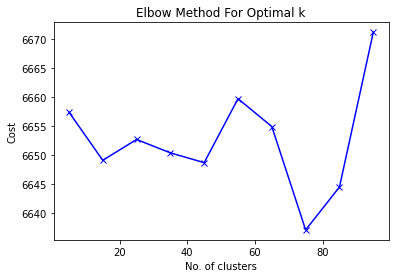

In [ ]:
# Elbow curve to find optimal K
cost = []
K = range(5,100,10)
for num_clusters in list(K):
    kmeans.fit_predict(X)
    cost.append(kmeans[-1].inertia_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
# Building the model with 3 clusters
kms = KMeans(n_clusters=55, init = "k-means++", n_init = 10, verbose=1)
kmeans = make_pipeline(normalizer, kms)
clusters = kmeans.fit_predict(X)
clusters

Initialization complete
Iteration 0, inertia 11894.413130075785.
Iteration 1, inertia 8314.158672725793.
Iteration 2, inertia 8082.136914973828.
Iteration 3, inertia 7974.341640767005.
Iteration 4, inertia 7924.9883343855945.
Iteration 5, inertia 7905.887517870535.
Iteration 6, inertia 7896.443458172594.
Iteration 7, inertia 7889.101440060032.
Iteration 8, inertia 7879.954268905702.
Iteration 9, inertia 7870.206716640874.
Iteration 10, inertia 7862.781211302045.
Iteration 11, inertia 7859.806916123468.
Iteration 12, inertia 7857.404215160505.
Iteration 13, inertia 7854.153531267721.
Iteration 14, inertia 7850.836280224497.
Iteration 15, inertia 7847.983172203254.
Iteration 16, inertia 7845.662823524532.
Iteration 17, inertia 7843.417749104086.
Iteration 18, inertia 7841.237237075482.
Iteration 19, inertia 7838.745937107466.
Iteration 20, inertia 7835.569654371946.
Iteration 21, inertia 7832.787639347207.
Iteration 22, inertia 7830.235942188781.
Iteration 23, inertia 7828.346362217173.


array([26,  6, 48, ...,  9, 49, 41])

In [ ]:
kmeans_ranking_df = units_composition_df.copy()
kmeans_ranking_df.insert(0, "group", clusters, True)

In [ ]:
kmeans_ranking_df

,group,placement,TFT7_Aatrox,TFT7_Anivia,TFT7_AoShin,TFT7_Ashe,TFT7_AurelionSol,TFT7_Bard,TFT7_Braum,TFT7_Corki,...,Set7_Scalescorn,Set7_Shapeshifter,Set7_Shimmerscale,Set7_SpellThief,Set7_Starcaller,Set7_Swiftshot,Set7_Tempest,Set7_Trainer,Set7_Warrior,Set7_Whispers
22282,26,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
19431,6,1,0,0,0,0,2,2,0,0,...,0,0,0,1,1,0,0,0,0,0
26376,48,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
9139,28,1,0,0,0,2,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
3573,7,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25870,32,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
17770,9,8,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,2
3989,9,8,0,0,0,0,0,1,0,0,...,0,0,0,1,1,0,1,0,0,2
17754,49,8,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [ ]:
kmeans_ranking_df = get_unit_composition_ranking(kmeans_ranking_df, add_trait=False)

In [ ]:
kmeans_ranking_df

,placement,group,comp
20505,8,0,"Anivia, Ashe, Karma, Ornn, Sejuani, Volibear"
12002,2,0,"Anivia, Hecarim, Karma, LeeSin, Nunu, Ornn, Sejuani, Volibear"
30513,7,0,"Anivia, Ashe, Hecarim, Nunu, Ornn, Volibear, Yasuo"
4863,6,0,"Anivia, Ashe, Hecarim, Karma, Nunu, Ornn, Sejuani, Volibear"
11164,1,0,"Anivia, Ashe, Hecarim, Lillia, Nunu, Ornn, Sejuani, Soraka, Volibear, Yasuo"
...,...,...,...
21301,1,49,"Bard, DragonBlue, DragonGreen, DragonPurple"
5815,6,49,"Ashe, DragonBlue, Karma, Neeko, Sona, Volibear, Yasuo"
28803,8,49,"DragonBlue, DragonGold, DragonPurple, Thresh, Yasuo"
6883,3,49,"DragonBlue, DragonGold, DragonGreen, DragonPurple, Leona"


In [ ]:
kmeans_ranking_df['grp_count'] = kmeans_ranking_df.groupby(['group'], as_index=False)['group'].transform('count')
kmeans_ranking_df['grp_placement'] = kmeans_ranking_df.groupby(['group'], as_index=False)['placement'].transform('mean')

In [ ]:
kmeans_ranking_df['mode'] = kmeans_ranking_df.groupby('group')['comp'].transform(lambda x: pd.Series.mode(x)[0])
kmeans_ranking_df.groupby(['group']).head(1).sort_values(by='grp_placement')

,placement,group,comp,grp_count,grp_placement,mode
4087,5,35,"Bard, DragonGreen, Gnar, Neeko, Pyke, Soraka, Talon",702,3.042735,"Bard, DragonGreen, Gnar, Neeko, Pyke, Soraka, Talon, Yasuo"
27492,6,37,"AoShin, Lulu, Nami, Ornn, Sona, Sylas, Zoe",215,3.483721,"AoShin, Bard, Ornn, Ryze, Soraka, Sylas, Yasuo, Zoe"
2559,3,8,"Anivia, Bard, DragonGreen, Gnar, Lulu, Neeko, Yasuo",933,3.771704,"Anivia, Bard, DragonGreen, Gnar, Lulu, Neeko, Yasuo"
22653,2,18,"Bard, DragonPurple, Pyke, Ryze, Sylas, Talon, Yasuo, Zoe",736,3.927989,"DragonPurple, Ornn, Pyke, Shen, Sylas, Talon, Thresh"
20701,5,30,"AoShin, Bard, Heimerdinger, Lulu, Neeko, Ornn, Sylas, TrainerDragon",375,3.946667,"AoShin, Heimerdinger, Lulu, Nami, Ornn, Sylas, TrainerDragon, Zoe"
26683,1,22,"DragonPurple, Ezreal, Illaoi, Ornn, Sylas, Twitch, Varus",557,4.012567,"DragonPurple, Illaoi, Ornn, Sylas, Twitch, Varus"
6522,6,43,"Ashe, Elise, Gnar, Neeko, Nidalee, Shyvana, Swain",400,4.067500,"Elise, Gnar, Neeko, Nidalee, Shyvana, Soraka, Swain"
4857,5,10,"Corki, DragonPurple, Lulu, Ornn, Shen, Sona, TrainerDragon, Tristana",465,4.141935,"Bard, Corki, DragonPurple, Lulu, Sona, Sylas, TrainerDragon, Tristana"
27485,2,44,"AoShin, DragonGold, DragonGreen, Shyvana, Yasuo",337,4.142433,"AoShin, DragonGold, DragonPurple, Ornn, Thresh"
18421,3,23,"Diana, DragonPurple, Kayn, Ornn, Qiyana, Sylas, Talon",677,4.147710,"Diana, DragonPurple, Kayn, Ornn, Pyke, Qiyana, Talon"


In [ ]:
kmeans_ranking_df.to_csv(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{PATCH}_kmeans_comp_ranking.csv'), index=False)

## DBSCAN

In [ ]:
units_composition_df = units_comp_df.copy()
X = units_composition_df.copy()
X.pop(TARGETNAME)

22282    1
19431    1
26376    1
9139     1
3573     1
        ..
25870    8
17770    8
3989     8
17754    8
22279    8
Name: placement, Length: 30848, dtype: int64

In [ ]:
units_composition_df.shape

(30848, 88)

In [ ]:
# Building the model with 3 clusters
# normalization to improve the k-means result.
normalizer = Normalizer(copy=False)
dbs= DBSCAN(eps=0.37, metric='euclidean', min_samples=3, n_jobs=-1) #eps=0.053, metric='cosine'
dbscan = make_pipeline(normalizer, dbs)
clusters = dbscan.fit_predict(X)
clusters

array([ 0, -1,  1, ..., -1, -1, -1], dtype=int64)

In [ ]:
dbscan_ranking_df = units_composition_df.copy()
dbscan_ranking_df.insert(0, "group", clusters, True)

In [ ]:
dbscan_ranking_df

,group,placement,TFT7_Aatrox,TFT7_Anivia,TFT7_AoShin,TFT7_Ashe,TFT7_AurelionSol,TFT7_Bard,TFT7_Braum,TFT7_Corki,...,Set7_Scalescorn,Set7_Shapeshifter,Set7_Shimmerscale,Set7_SpellThief,Set7_Starcaller,Set7_Swiftshot,Set7_Tempest,Set7_Trainer,Set7_Warrior,Set7_Whispers
22282,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
19431,-1,1,0,0,0,0,2,2,0,0,...,0,0,0,1,1,0,0,0,0,0
26376,1,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
9139,-1,1,0,0,0,2,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
3573,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25870,6,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
17770,2,8,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,2
3989,-1,8,0,0,0,0,0,1,0,0,...,0,0,0,1,1,0,1,0,0,2
17754,-1,8,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [ ]:
dbscan_ranking_df = get_unit_composition_ranking(dbscan_ranking_df, add_trait=False)

In [ ]:
dbscan_ranking_df

,placement,group,comp
8174,4,-1,"Braum, Leona, Shen, Yone"
7816,5,-1,"DragonBlue, Hecarim, Leona, Nunu, Taric, Yasuo"
21839,5,-1,"DragonPurple, Elise, Nunu, Pyke, Sejuani, Sylas, Talon, Twitch"
22981,5,-1,"Bard, Corki, DragonGreen, Gnar, Jinx, Neeko, Sona"
7162,5,-1,"DragonGreen, Gnar, Hecarim, Neeko, Shen, Soraka, Sylas"
...,...,...,...
26901,6,244,"Anivia, Ashe, DragonGreen, Hecarim, Neeko, Swain, Xayah"
2967,8,244,"Anivia, Ashe, DragonGreen, Neeko, Sett, Swain, Xayah"
9042,6,245,"Diana, DragonGold, Kayn, Pyke, Qiyana, Talon, Thresh"
29457,5,245,"Diana, DragonGold, Kayn, Qiyana, Talon, Thresh, Yasuo"


In [ ]:
dbscan_ranking_df['grp_count'] = dbscan_ranking_df.groupby(['group'], as_index=False)['group'].transform('count')
dbscan_ranking_df['grp_placement'] = dbscan_ranking_df.groupby(['group'], as_index=False)['placement'].transform('mean')
dbscan_ranking_df['mode'] = dbscan_ranking_df.groupby('group')['comp'].transform(lambda x: pd.Series.mode(x)[0])
dbscan_ranking_df.groupby(['group']).head(1).sort_values(by='grp_count', ascending=False)[:60]

,placement,group,comp,grp_count,grp_placement,mode
5086,6,0,"DragonBlue, Hecarim, Nunu, Ornn, Sejuani, Yasuo, Yone",7932.0,4.543566,"DragonBlue, Hecarim, Leona, Nunu, Sejuani, Yasuo, Yone"
29599,4,3,"AoShin, Bard, Gnar, Neeko, Ornn, Soraka, Yasuo",6370.0,3.545455,"AoShin, Bard, Gnar, Lulu, Neeko, Ornn, Soraka, Yasuo"
16842,5,2,"DragonPurple, Illaoi, Olaf, Ornn, Qiyana, Shen, Sylas, Talon",3965.0,4.238619,"DragonPurple, Ornn, Pyke, Qiyana, Shen, Sylas, Thresh"
1843,8,6,"Hecarim, Ornn, Qiyana, Shen, Talon, Twitch, Xayah",3829.0,4.334087,"Hecarim, Ornn, Qiyana, Sejuani, Shen, Talon, Twitch, Xayah"
18880,2,7,"AoShin, DragonGold, DragonPurple, Ornn, Thresh",3538.0,2.947368,"AoShin, DragonGold, DragonPurple, Ornn, Thresh"
10689,5,1,"Heimerdinger, Illaoi, Lulu, Nami, Ryze, Sylas, TrainerDragon, Tristana, Zoe",1733.0,4.522068,"Bard, Braum, Corki, DragonGold, Lulu, Sona, TrainerDragon, Tristana"
18416,1,5,"Anivia, Corki, DragonGreen, Gnar, Heimerdinger, Lulu, Neeko, Soraka, TrainerDragon",1040.0,4.109167,"Anivia, Bard, DragonGreen, Gnar, Lulu, Neeko, Yasuo"
20425,5,46,"Braum, DragonBlue, Leona, Shen, Taric, Thresh, Yone",196.0,5.833333,"Braum, Leona, Shen, Taric, Thresh, Yone"
7768,6,11,"AoShin, Bard, Neeko, Ornn, Sylas, Yasuo, Zoe",168.0,1.666667,"AoShin, Bard, Ornn, Ryze, Soraka, Sylas, Yasuo, Zoe"
17365,1,27,"Illaoi, Ornn, Qiyana, Soraka, Talon, Twitch, Varus",159.0,1.750000,"Bard, Illaoi, Ornn, Qiyana, Soraka, Talon, Twitch, Varus, Yasuo"


In [ ]:
dbscan_ranking_df.to_csv(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{PATCH}_dbscan_comp_ranking.csv'), index=False)